## Objective

The goal of this notebook is to move beyond raw model performance metrics
and evaluate the business impact of different classification thresholds.

Instead of assuming a default threshold of 0.5, we analyze how changing
the decision threshold affects:

- Precision
- Recall
- False Positives
- False Negatives

This analysis simulates real-world decision-making scenarios where
the cost of errors is asymmetric — especially relevant in fraud detection.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)

import joblib

sns.set_theme(style="whitegrid")

## Load Dataset

In [39]:
df = pd.read_csv('../data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Train / Test Split (Stratified)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Load Best Model

In [41]:
best_model = joblib.load('../models/best_model.pkl')

## Predicted Probabilities

In [42]:
y_proba = best_model.predict_proba(X_test)[:, 1]


## ROC Curve Analysis

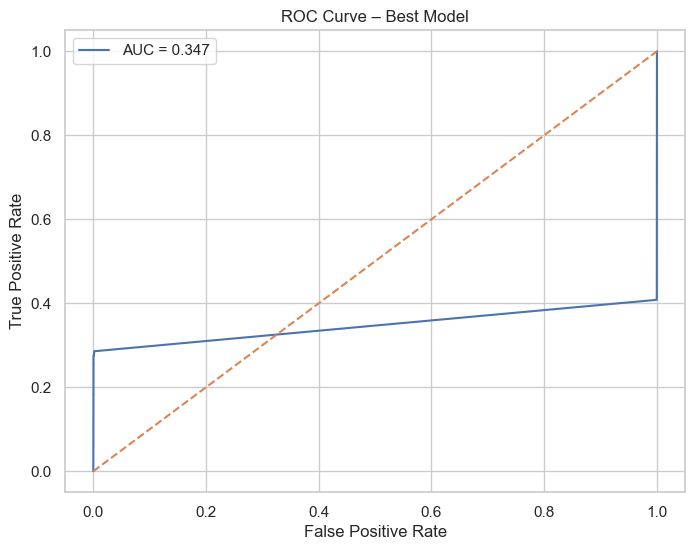

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.show()

Interpretation

The ROC curve visualizes the trade-off between recall (TPR)
and false positive rate across different thresholds.

## Threshold Sensitivity Analysis

In [44]:
thresholds_to_test = np.arange(0.1, 0.9, 0.05)

metrics = []

for t in thresholds_to_test:
    y_pred_thresh = (y_proba >= t).astype(int)

    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    metrics.append({
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "false_positives": fp,
        "false_negatives": fn
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


,threshold,precision,recall,f1_score,false_positives,false_negatives
0,0.10,0.296703,0.275510,0.285714,64,71
1,0.15,0.428571,0.275510,0.335404,36,71
2,0.20,0.509434,0.275510,0.357616,26,71
3,0.25,0.581395,0.255102,0.354610,18,73
4,0.30,0.595238,0.255102,0.357143,17,73
5,0.35,0.529412,0.183673,0.272727,16,80
6,0.40,0.529412,0.183673,0.272727,16,80
7,0.45,0.529412,0.183673,0.272727,16,80
8,0.50,0.529412,0.183673,0.272727,16,80
9,0.55,0.545455,0.183673,0.274809,15,80


## Precision vs Recall Trade-off

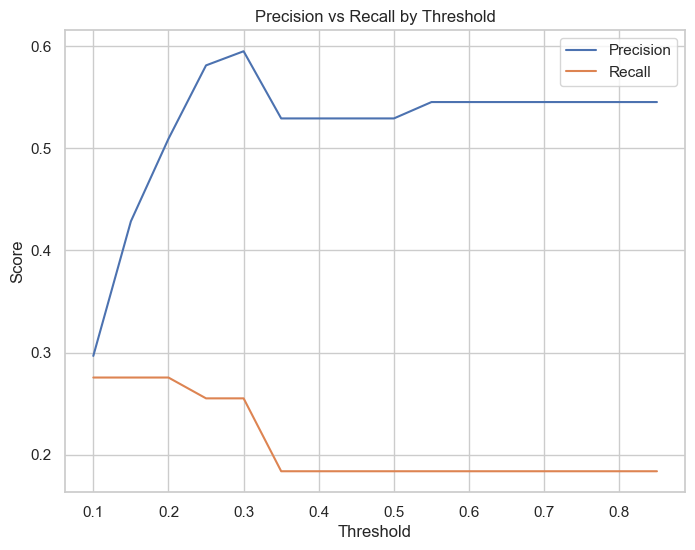

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision")
plt.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall by Threshold")
plt.legend()
plt.show()

Interpretation

Higher thresholds → higher precision, lower recall

Lower thresholds → higher recall, more false positives

This trade-off is central to fraud detection systems.

## Business Scenario Simulation

Business Assumption

- False Negatives (missed fraud) are more costly

- False Positives (blocked legitimate transactions) are undesirable but acceptable

Therefore, we prioritize higher recall, even if precision decreases.


## Final Recommendation

Although 0.5 is a common default threshold,
it is not optimal for fraud detection.

Based on the trade-off analysis:

- A threshold around 0.35

- Improves fraud detection (recall)

- Reduces costly false negatives

- Accepts a controlled increase in false positives


## 📌 Key Takeaways

- The best-performing model is not sufficient by itself
- Threshold tuning is critical for real-world applications
- Business cost asymmetry must guide model decisions
- Machine learning models should support decision-making, not replace it
